In [1]:
import pandas as pd
import os
import tensorflow as tf
import albumentations as A

In [2]:
tf.__version__

'2.4.0'

In [3]:
# create data set
path2data = "/home/Data/"

In [4]:
test_df = pd.read_csv(os.path.join(path2data, 'all/testing.csv'))
test_df.drop("Unnamed: 0", axis = 1, inplace=True)

In [5]:
columns = ['age', 'gender']

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./",
    x_col= "file_name",
    y_col= columns,
    batch_size = 256,
    seed=42, 
    shuffle=False,
    class_mode = "raw",
    target_size = (224, 224)
)

Found 10000 validated image filenames.


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.5)
])

In [ ]:
best_model = tf.keras.models.load_model('../models/age_gender.h5')

best_model.summary()

In [18]:
def generator_wrapper(generator):
    for batch_x, batch_y in generator:
        yield (batch_x,[batch_y[:,i] for i in range(2)])

In [19]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
results = best_model.evaluate(generator_wrapper(test_generator), steps = STEP_SIZE_TEST, verbose = 1)

39/39 [==============================] - 65s 320ms/step - loss: 88.1019 - age_loss: 87.7577 - gender_loss: 0.3443 - age_age_mean_absolute_error: 6.6015 - gender_gender_binary_accuracy: 0.8352


In [81]:
def plot_imgs(imgs, cols=4, size=7, is_rgb=True, titles=[], img_size=(224,224)):
    rows = len(imgs)//cols
    fig, ax = plt.subplots(rows, cols, figsize=(cols*size, rows*size))
    
    count = 0
    for i in range(rows):
        for j in range(cols):
            if img_size is not None:
                img = cv2.resize(imgs[count], img_size)
            ax[i, j].imshow(img)
            ax[i, j].set_title(f'age: {int(titles[count][0])} gender: {titles[count][1]}')
            count+=1
        
    plt.show()

In [84]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

np.random.seed(1999)

def predict(model, img_paths):
    choose_imgs = np.random.choice(img_paths, size = 8)
    
    preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
    pred_imgs = []
    titles = []
    for img_name in choose_imgs:
        img = cv2.imread(img_name)
        out = deepcopy(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32')
        
        img = cv2.resize(img, (224,224))
        img = preprocess_input(img)
        img = np.expand_dims(img, 0)
        age, gender = model.predict(img, batch_size= 1)
        
        gender = tf.keras.activations.sigmoid(gender)
        gender = int(gender > 0.5)

        titles.append((age, gender))
        pred_imgs.append(out)
    
    plot_imgs(pred_imgs, titles=titles)

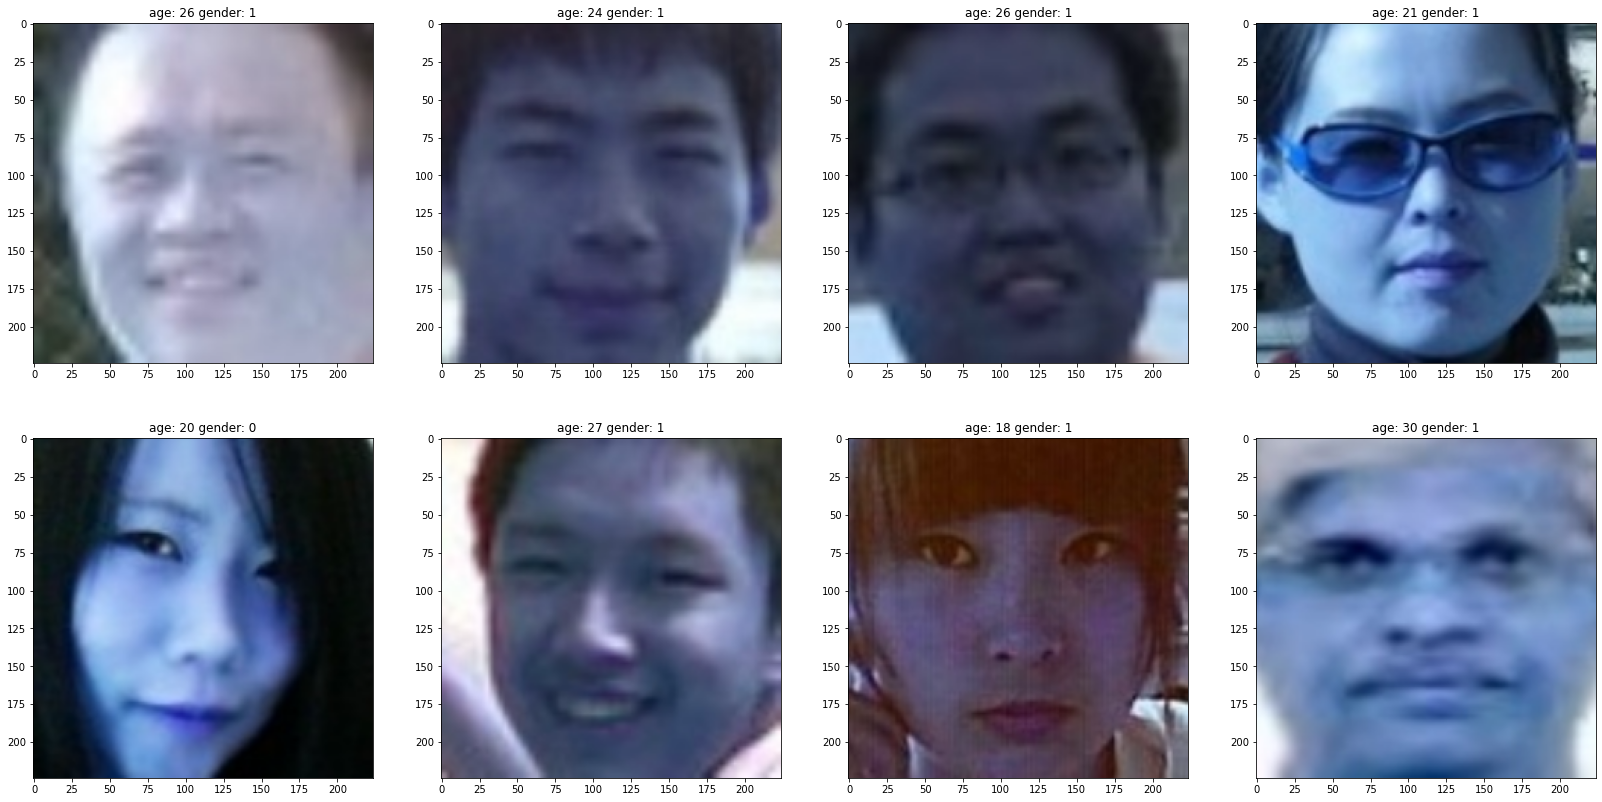

In [85]:
img_paths = list(test_df['file_name'].values)

predict(best_model, img_paths)

In [94]:
all_df = pd.concat([pd.read_csv(path2data + 'appa-real/processed/test.csv'), pd.read_csv(path2data + 'appa-real/processed/train.csv'), pd.read_csv(path2data + 'appa-real/processed/valid.csv')])

In [95]:
columns = ['age', 'gender']

all_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
all_generator = all_datagen.flow_from_dataframe(
    dataframe=all_df,
    directory="./",
    x_col= "file_name",
    y_col= columns,
    batch_size = 256,
    seed=42, 
    shuffle=False,
    class_mode = "raw",
    target_size = (224, 224)
)

Found 7473 validated image filenames.


In [96]:
STEP_SIZE_ALL=all_generator.n//all_generator.batch_size
results = best_model.evaluate(generator_wrapper(all_generator), steps = STEP_SIZE_ALL, verbose = 1)

29/29 [==============================] - 24s 855ms/step - loss: 220.8958 - age_loss: 220.3594 - gender_loss: 0.5364 - age_age_mean_absolute_error: 10.9638 - gender_gender_binary_accuracy: 0.7558


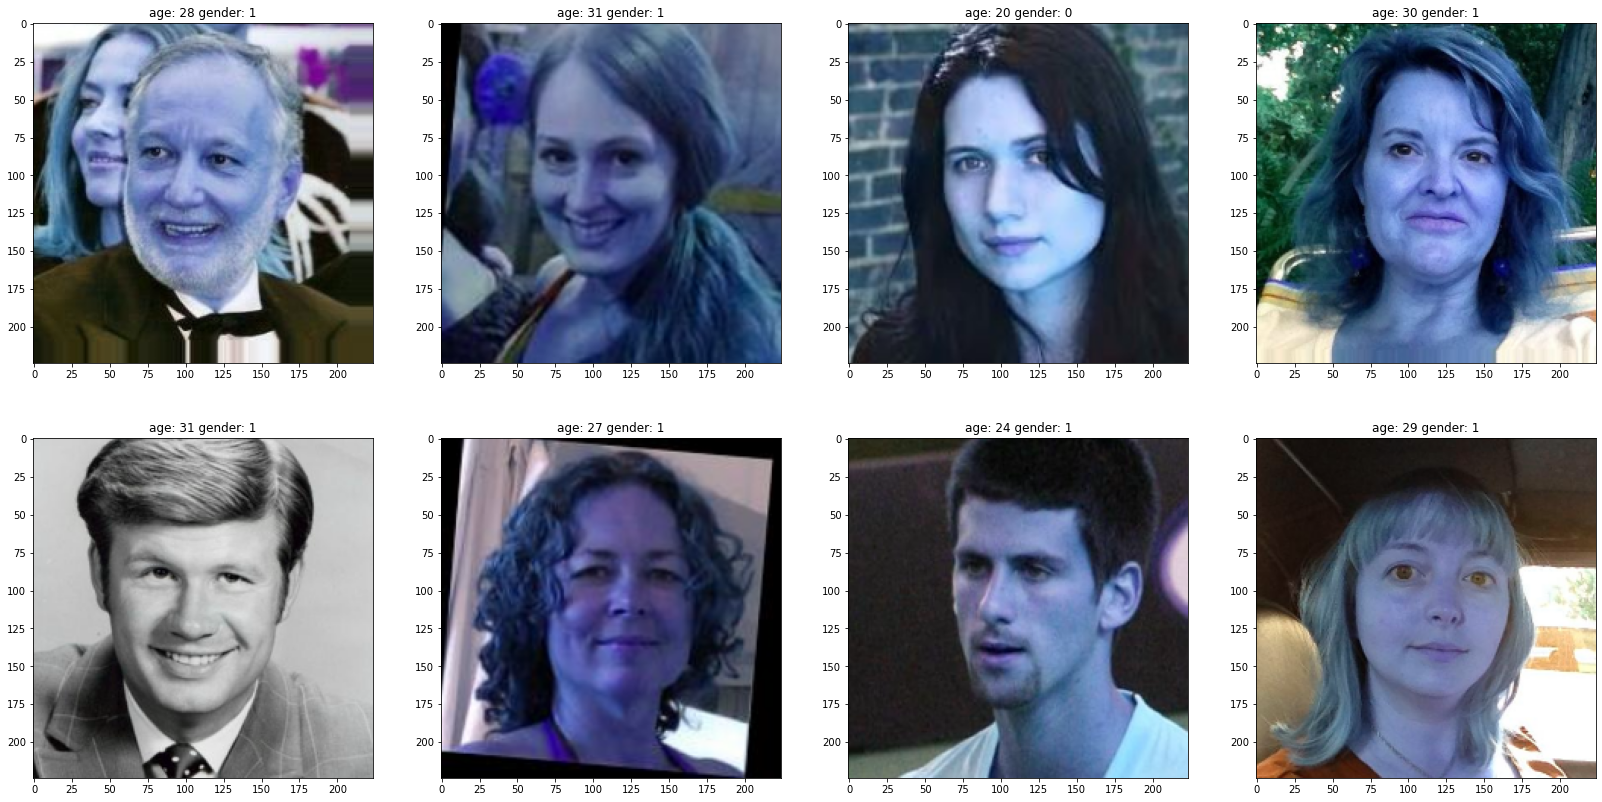

In [97]:
img_paths = list(all_df['file_name'].values)

predict(best_model, img_paths)

In [73]:
TFLITE_QUANT_MODEL = '../models/age_gender_mobilenetv3_v1.tflite'
test_image_batch, test_label_batch = next(iter(test_generator))

# Load quantized TFLite model
tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_QUANT_MODEL)

# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

# Resize input and output tensors to handle batch of 32 images
tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (256, 224, 224, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (256, 2))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

# Run inference
tflite_interpreter_quant.set_tensor(input_details[0]['index'], test_image_batch)

tflite_interpreter_quant.invoke()

tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
print("\nPrediction results shape:", tflite_q_model_predictions.shape)

== Input details ==
name: input_4
shape: [256 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [256   2]
type: <class 'numpy.float32'>

Prediction results shape: (256, 1)


In [83]:
# Convert prediction results to Pandas dataframe, for better visualization

# tflite_q_model_predictions = 
tflite_q_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe.columns = ['age', 'gender']

print("Quantized TFLite model prediction results for the first elements")
tflite_q_pred_dataframe.head()

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements